## Create micromagnetic system

In [1]:
import discretisedfield as df
import micromagneticmodel as mm
import matplotlib.pyplot as plt
import oommfc as oc
import random
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='svg'
thickness = 2e-9
cell = (2e-9, 2e-9, 2e-9)
p1 = (-400e-9, -50e-9, -thickness/2)
p2 = (400e-9, 50e-9, thickness/2)
region=df.Region(p1=p1,p2=p2)
mesh = df.Mesh(region=region, cell=cell)
system = mm.System(name='skyrmion_dynamics')


In [2]:
def initial_state(pos):
    x, y = pos[0], pos[1]
    if ((x+300e-9)**2+y**2)**0.5<20e-9:
        m = (0,0,-1)
    else:
        m = (0, 0, 1)
    return m
system.dynamics = mm.Precession(gamma0=mm.consts.gamma0) + mm.Damping(alpha=0.3)
system.energy = mm.Exchange(A=1e-11)+mm.DMI(D=3.2e-3, crystalclass='Cnv_z')+mm.UniaxialAnisotropy(K=0.8e6, u=(0,0,1))
system.m =  df.Field(mesh, dim=3, value=initial_state, norm=5.8e5)
ad = oc.MinDriver()
ad.drive(system)

Running OOMMF (ExeOOMMFRunner)[2022/09/20 20:37]... (8.4 s)


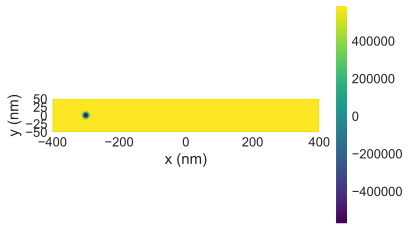

In [3]:
system.m.z.plane('z').mpl.scalar()

In [4]:
import micromagneticdata as md
data=md.Data(system.name)
data.info

,drive_number,date,time,driver
0,0,2022-09-20,20:37:16,MinDriver


In [5]:
system.dynamics = mm.Precession(gamma0=mm.consts.gamma0) + mm.Damping(alpha=0.3) + mm.ZhangLi(u=300,beta=0.2)
system.energy = mm.Exchange(A=1e-11)+mm.DMI(D=3.2e-3, crystalclass='Cnv_z')+mm.UniaxialAnisotropy(K=0.8e6, u=(0,0,1))
system.m =data[0][0]
md = oc.TimeDriver()
md.drive(system,t=1e-9,n=50,verbose=2)

Running OOMMF (ExeOOMMFRunner):   0%|          | 0/50 files written [00:00]

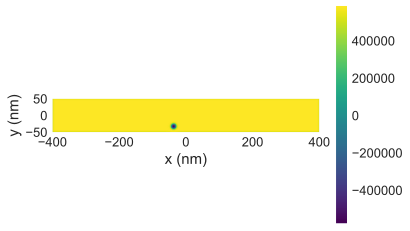

In [6]:
data[1][-1].z.plane('z').mpl.scalar()

In order to draw the motion track of skyrmion, we first need to capture the center point of skyrmion, where the center point can be defined by the following formula through the topological density：

\begin{equation}
x_{s k}=\frac{\int x q d x d y}{\int q d x d y}, y_{s k}=\frac{\int y q d x d y}{\int q d x d y}\tag{1}
\end{equation}
where 
\begin{equation}
q=\frac{1}{4 \pi} \boldsymbol{m} \cdot\left(\frac{\partial m}{\partial x} \times \frac{\partial m}{\partial y}\right) .\tag{2}
\end{equation}

In ubermag, this method can be implemented with the following two codes: one is to use the discretisedfield tool, and the other is to directly create functions.

In [7]:
import discretisedfield. tools as dft
def sk_location(l,n,pz):
    X=[]
    Y=[]
    for i in range(n):
        m = data[l][i].orientation.plane(z=pz)
        q = m @ (m.derivative('x') & m.derivative('y'))
        Q = df.integral(q * df.dx * df.dy) / (4 * np.pi)
        x = df.Field(data[l][i].plane(z=pz).mesh, dim =1, value = lambda pos:pos[0])
        y = df.Field(data[l][i].plane(z=pz).mesh, dim =1, value = lambda pos:pos[1])
        Rx = df.integral(x * q * df.dx * df.dy) / df.integral(q * df.dx * df.dy)
        Ry = df.integral(y * q * df.dx * df.dy) / df.integral(q * df.dx * df.dy)
        X.append(Rx)
        Y.append(Ry)
    return X,Y

def guiding_centre(field):
    q = dft.topological_charge_density(field)
    x = df.Field(field.mesh, dim=1, value=lambda point: point[0])
    y = df.Field(field.mesh, dim=1, value=lambda point: point[1])
    rx = df.integral(x*q*df.dx*df.dy) / df.integral(q*df.dx*df.dy)
    ry = df.integral(y*q*df.dx*df.dy) / df.integral(q*df.dx*df.dy)
    return (rx, ry)

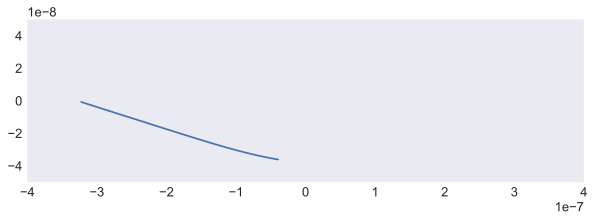

In [12]:
X=[]
Y=[]
for i in range(50):
    x=guiding_centre(data[1][i].plane(z=0))[0]
    y=guiding_centre(data[1][i].plane(z=0))[1]
    X.append(x)
    Y.append(y)
fig=plt.figure(figsize=(10,3),dpi=100)
ax=fig.add_subplot(111)
ax.set_xlim(-400e-9,400e-9)
ax.set_ylim(-50e-9,50e-9)
ax.plot(X,Y)

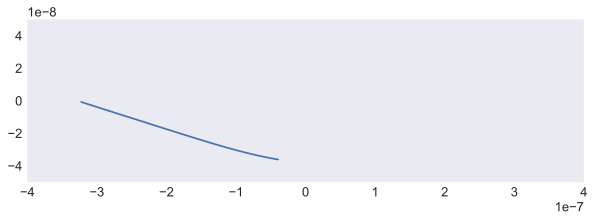

In [13]:
fig=plt.figure(figsize=(10,3),dpi=100)
ax=fig.add_subplot(111)
ax.set_xlim(-400e-9,400e-9)
ax.set_ylim(-50e-9,50e-9)
ax.plot(sk_location(l=1,n=50,pz=0)[0],sk_location(l=1,n=50,pz=0)[1])

After obtaining the skyrmion center point, it is easy to calculate its instantaneous velocity

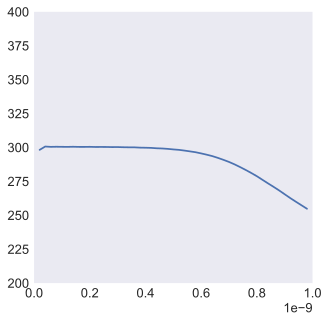

In [29]:
def sk_velocity(l,n,pz): 
    t = data[l].table.data['t']
    delta_X = []
    delta_Y = []
    delta_T = []
    for i in range(len(sk_location(l=l,n=n,pz=pz)[0])-1):
        delta_x = X[i+1] - X[i]
        delta_X.append(delta_x)
    for i in range(len(sk_location(l=l,n=n,pz=pz)[1])-1):
        delta_y = Y[i+1] - Y[i]
        delta_Y.append(delta_y)
    for i in range(len(t)-1):
        delta_t = t[i+1] - t[i]
        delta_T.append(delta_t)
    R = list(map(lambda x,y:np.sqrt(x**2+y**2),delta_X,delta_Y))
    v = list(map(lambda x,y: x/y,R,delta_T))
    return t,v,delta_X,delta_Y,delta_T
fig=plt.figure(figsize=(5,5),dpi=100)
ax=fig.add_subplot(111)
ax.set_xlim(0,1e-9)
ax.set_ylim(200,400)
ax.plot(sk_velocity(l=1,n=50,pz=0)[0][:-1],sk_velocity(l=1,n=50,pz=0)[1])